In [1]:
import pandas as pd
from pandas import option_context
import glob
import sys
sys.path.append('E:\GitHubProjects\dissertation\Scripts')
import helperfn as hf

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_colwidth', -1)

df = hf.merge_datasets(r'E:\GitHubProjects\dissertation\scraper\approved_datasets')


# df.iloc[[363,367]]

In [3]:
df.iloc[[363,367]]

,review,score
363,Fantastic environment and gorgeoud scenery. The clubs and societies provide great opportunities to meet life long friends.,1
367,Wifi drops off easily and applying for accommodation is stressful,0


In [3]:
# BALANCING THE DATASET
df.score.value_counts()


1    1068
0    567 
Name: score, dtype: int64

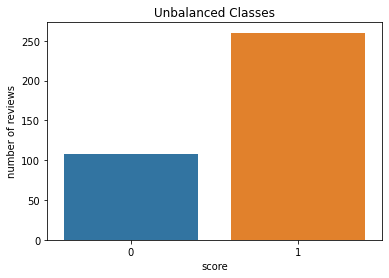

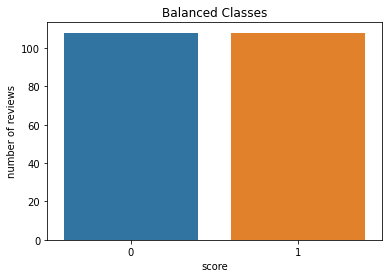

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Shuffle the dataset
shuffled_df = df.sample(frac=1, random_state=14)

# Put all negative reviews/class in a separate dataset.
negative_df = shuffled_df.loc[shuffled_df['score'] == 0]

#Randomly select 108 postive reviews (majority class), as there are 108 negative reviews
positive_df = shuffled_df.loc[shuffled_df['score'] == 1].sample(n=negative_df.shape[0])

# Concatenate both dataframes again
normalized_df = pd.concat([negative_df, positive_df])


sns.countplot('score', data=df)
plt.title('Unbalanced Classes')
plt.ylabel('number of reviews')
plt.show()



sns.countplot('score', data=normalized_df)
plt.title('Balanced Classes')
plt.ylabel('number of reviews')
plt.show()

In [6]:
# TEST-SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['score'], test_size=0.33)

In [2]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
import re

#converting list to set for perofmance gains, when hcecking if word is present in stoplist
stoplist = set(stopwords.words('english'))
punctuations = {'"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'}


# tt = TweetTokenizer()
# tokenizer = RegexpTokenizer(r'[\w\'\!]+')
#TODO: dont segment Apostrophe if no space between e.g. whats'up but segment gg ' gg

#removal of puncuations
def remove_punctuations(text):
    text_nopunct = re.sub('\!\!+', '!', text)
    # text_nopunct = re.sub('['+punctuations+']', '', text)
    return text_nopunct

print(remove_punctuations("HELLO.!!!"))

#lower case tokens
def lower_token(tokens): 
    return [w.lower() for w in tokens]  

#remove stop words
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

# df['review'] = df['review'].apply(lambda x: remove_punctuations(x))
tokens = [tt.tokenize(rev) for rev in df.review]
lower_tokens = [lower_token(token) for token in tokens]
filtered_words = [removeStopWords(sen) for sen in lower_tokens]

df['tokens'] = filtered_words


HELLO.!


NameError: name 'df' is not defined

In [19]:
df['tokens']

0      [shambles, completely, unorganised, clearly, i...
1      [school, absolute, b, im, msc, computing, prof...
2      [international, student, lecturers, great, onl...
3      [terrible, experience, university, considered,...
4      [love, university, staff, extremely, helpful, ...
                             ...                        
363    [fantastic, environment, gorgeoud, scenery, cl...
364    [campus, contains, everything, could, ever, ne...
365     [campus, beautiful, offers, 100, clubssocieties]
366    [im, study, highland, campus, inverness, stude...
367    [wifi, drops, easily, applying, accommodation,...
Name: tokens, Length: 368, dtype: object

In [1]:
string.punctuation

NameError: name 'string' is not defined